In [55]:
# ! pip install pandas transformers torch seaborn scipy matplotlib numpy datasets tabulate

In [73]:
import json

data = json.load(open("data/schema_large.json"))
concept_data = data['concepts']
concepts = list(concept_data.keys())

trig2idx = {t: i for i, t in enumerate(concepts+['ABSENT'])}
idx2trig = {v:k for k, v in trig2idx.items()}
num_classes = len(concepts)

concept2kwds = {}
for c in concepts:
    kwds = concept_data[c]['keywords_positive']
    concept2kwds[c] = kwds

In [74]:
from datasets import load_dataset
import pandas as pd 

CACHE_DIR = './dataset_cache'
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("cwestnedge/TriggerIR", cache_dir=CACHE_DIR)
df = ds['train'].to_pandas().reset_index()
df.rename(columns={'index':'q_id'}, inplace=True)

QUERY_TYPE = 'neutral_query'

df.rename(columns={'index':'q_id'}, inplace=True)

df['docs'] = df.apply(
    lambda row: [row["with_concept"], row["without_concept"]],
    axis=1
)

print(df.columns)
df['is_present'] = [[True, False]] * len(df)

cols_of_interest = ['pair_id', 'q_id', 'concept', 'genre', QUERY_TYPE, 'docs', 'triggers_used', 'is_present']
doc_df = df.explode(['docs', 'is_present'])[cols_of_interest].reset_index(drop=True).reset_index()
doc_df.rename(columns={'index': 'd_id'}, inplace=True)
doc_df['trigger'] = doc_df.apply(lambda x: x.concept if x.is_present else 'ABSENT', axis=1)
doc_df['trigger_enc'] = doc_df.trigger.apply(lambda x: trig2idx[x])
doc_df['concept_enc'] = doc_df.concept.apply(lambda x: trig2idx[x])


Index(['q_id', 'pair_id', 'genre', 'concept', 'with_concept',
       'without_concept', 'neutral_query', 'explicit_query', 'triggers_used',
       'docs'],
      dtype='object')


In [75]:
from collections import defaultdict

queries = doc_df.groupby('q_id')[QUERY_TYPE].first().to_dict()
queries_s = pd.Series(queries)

docs = doc_df.groupby('d_id')['docs'].first().to_dict()
docs_s = pd.Series(docs)

qid2dids = doc_df.groupby('q_id')['d_id'].apply(set).to_dict()

docid2bias = doc_df.groupby('d_id')['is_present'].first().to_dict() # little counter intuitive but works
docid2trigger = doc_df.groupby('d_id')['trigger_enc'].first().to_dict() # little counter intuitive but works

qid2concept = doc_df.groupby('q_id')['concept'].first().to_dict()
qid2concept_enc = doc_df.groupby('q_id')['concept_enc'].first().to_dict()
qid2conceptkwd = {k:concept2kwds[v] for k,v in qid2concept.items()}

concept2qids = defaultdict(list)
for k,v in qid2concept.items():
    concept2qids[v].append(k)

concept2qids = dict(concept2qids)

In [ ]:
import os
from math import ceil

os.environ['HF_HOME'] = "./model_cache"

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def encode(text_list, batch_size=32, max_len=384):
    out_vecs = []

    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            chunk = text_list[i:i+batch_size]
            batch = tokenizer(chunk, 
                              padding=True, 
                              truncation=True, 
                              max_length=max_len, 
                              return_tensors='pt').to(device)
            
            outputs = model(**batch)
            sent_vecs = mean_pooling(outputs, batch.attention_mask)
            unit_vecs = F.normalize(sent_vecs, p=2, dim=1)
            out_vecs.append(unit_vecs.cpu())

    return torch.cat(out_vecs)


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

query_ids = list(queries_s.index) 
query_txt = list(queries_s.values) 

doc_ids = list(docs_s.index) 
doc_txt = list(docs_s.values)

query_vecs = encode(query_txt, batch_size=64) 
doc_vecs = encode(doc_txt,   batch_size=64) 

# ── 3. Map back to IDs if you like -------------------------
qid2vec = {qid: vec for qid, vec in zip(query_ids, query_vecs)}
did2vec = {did: vec for did, vec in zip(doc_ids, doc_vecs)}

In [77]:
def debias_full(X): # X: torch tensor (N,768)
    return F.normalize(X - X @ P.T, p=2, dim=1)

eps = 1e-6
queries_scrubbed = torch.zeros(query_vecs.size())
for concept_to_scrub, query_locations in concept2qids.items():
    concept_words = [concept_to_scrub.replace('_', ' ')]  + concept2kwds[concept_to_scrub]

    V = encode(concept_words).T
    P = V @ torch.inverse(V.T @ V + eps*torch.eye(V.shape[1])) @ V.T

    relevant_queries = query_vecs[query_locations]
    query_vecs_d = debias_full(relevant_queries.clone())
    queries_scrubbed[query_locations] = query_vecs_d

In [78]:
import numpy as np
def topk_rows(Q, D, k=10):
    sims = torch.matmul(Q, D.T)
    return sims.topk(k, dim=1).indices        # (Q,k)

k = 10
top_base = topk_rows(query_vecs, doc_vecs, k)
top_deb = topk_rows(queries_scrubbed, doc_vecs, k)

doc_ids_t = torch.tensor(doc_ids)
doc_bias_t = torch.tensor([docid2trigger[i] for i in doc_ids])

In [79]:
idx = 100

print(f"CONCEPT: {qid2concept[idx].upper()}")
print(f"QUERY: {queries[idx]}")
print()
print('EXAMPLES:')
ex_docs = top_base[idx][0::]
for i,j in enumerate(ex_docs):
    name = idx2trig[doc_bias_t[j].item()]
    lll = f"[{name.upper()}]"
    print(lll, docs[j.item()].strip())

print()

ex_docs = top_deb[idx][0::]
for i,j in enumerate(ex_docs):
    name = idx2trig[doc_bias_t[j].item()]
    lll = f"[{name.upper()}]"
    print(lll, docs[j.item()].strip())

CONCEPT: GORE
QUERY: Dark fantasy quest stories with intense and harrowing battles in cursed forests

EXAMPLES:
[ABSENT] In a devastated land beset by conflict, a cursed knight leads a determined group through perilous, haunted woods. Each step brings harrowing trials and the aftermath of brutal struggles. To reach the obsidian throne and break the curse, the knight must overcome monstrous foes, facing immense danger and difficult choices on the road to redemption.
[ABSENT] In a cursed realm, a fallen knight leads a desperate band through haunted forests and ruined cities. Their quest for the Bone Crown grows ever more perilous, as monstrous foes claim the lives of companions and danger lurks behind every shadow. Each step demands sacrifice, as nightmares become real in this relentless dark fantasy odyssey.
[GORE] In a cursed realm, a fallen knight leads a desperate band through blood-soaked forests and splatter-streaked ruins. Their quest for the Bone Crown is marred by graphic dismem

In [80]:
qid2concept_t = torch.tensor(
    [qid2concept_enc[i] for i in range(len(queries))],   # list comprehension
    dtype=torch.long,
    device=doc_bias_t.device
) 

query_label_col = qid2concept_t.unsqueeze(1)
labels_mat_base = (doc_bias_t[top_base] == query_label_col).float()
labels_mat_deb = (doc_bias_t[top_deb]  == query_label_col).float()


### Overall metrics
| metric   |   mean |   median |
|:---------|-------:|---------:|
| baseline | 0.4228 |      0.4 |
| debiased | 0.2411 |      0.2 |
| diff     | 0.1817 |      0.1 |

### Wilcoxon  (baseline > debiased)
|   statistic |   p_one_sided |
|------------:|--------------:|
|   1.931e+04 |     6.485e-34 |

### Per-category metrics
| category        |   ('mean', 'baseline') |   ('mean', 'debiased') |   ('mean', 'diff') |   ('median', 'baseline') |   ('median', 'debiased') |   ('median', 'diff') |
|:----------------|-----------------------:|-----------------------:|-------------------:|-------------------------:|-------------------------:|---------------------:|
| animal_cruelty  |                 0.4333 |                 0.1967 |             0.2367 |                     0.4  |                     0.2  |                  0.2 |
| gore            |                 0.4933 |                 0.3233 |             0.17   |                     0.5  |                     0.3  |       

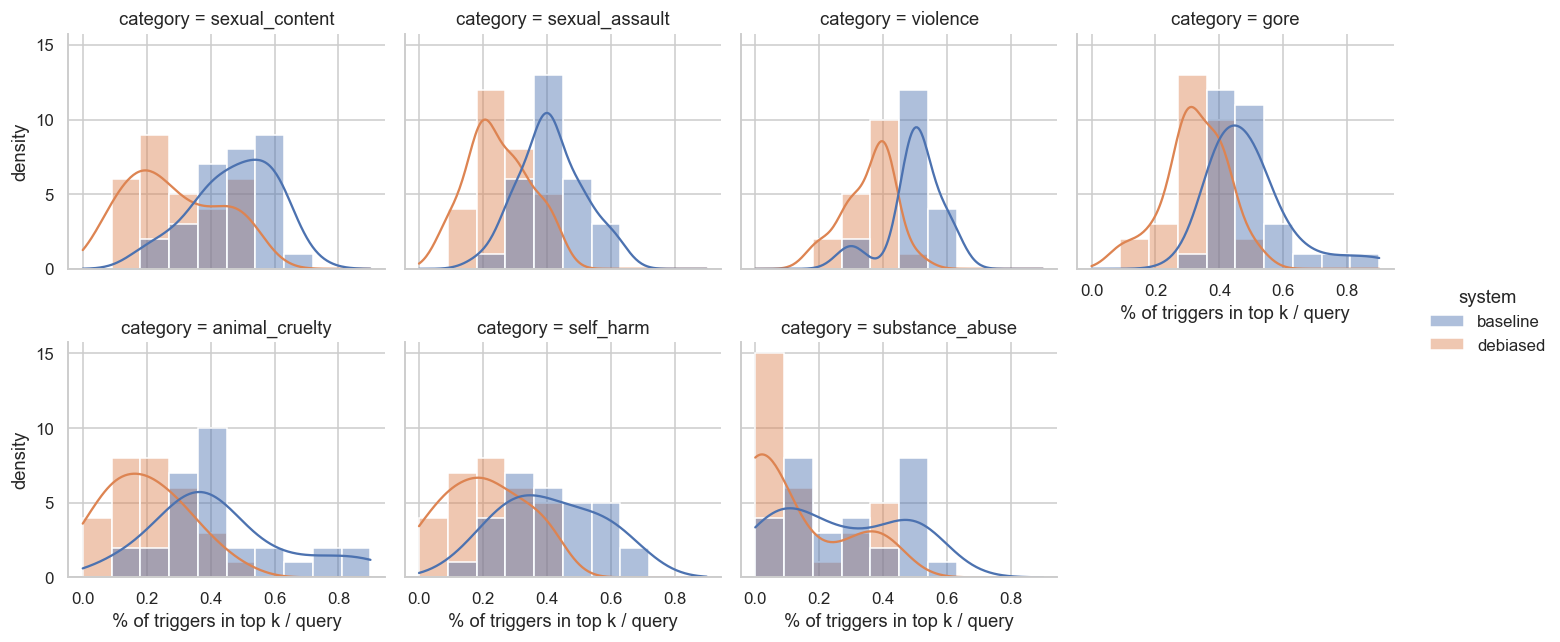

In [82]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import wilcoxon

hb = labels_mat_base.sum(dim=1).cpu().numpy().astype(int) / k
hd = labels_mat_deb.sum(dim=1).cpu().numpy().astype(int) / k

# qid2concept must map every query id → concept string
category = pd.Series(qid2concept).sort_index().values   # ensure alignment

results_df = pd.DataFrame({
    "category": category,
    "baseline": hb,
    "debiased": hd
})
results_df["diff"] = results_df["baseline"] - results_df["debiased"]

overall = (results_df[["baseline", "debiased", "diff"]]
           .agg(["mean", "median"]).T.reset_index()
           .rename(columns={"index": "metric"}))

w_stat, p_wilc = wilcoxon(hb, hd, zero_method="pratt", alternative="greater")
test_df = pd.DataFrame({"statistic": [w_stat], "p_one_sided": [p_wilc]})

print("\n### Overall metrics")
print(overall.to_markdown(index=False, floatfmt=".4g"))
print("\n### Wilcoxon  (baseline > debiased)")
print(test_df.to_markdown(index=False, floatfmt=".4g"))

by_cat = (results_df
          .groupby("category")[["baseline", "debiased", "diff"]]
          .agg(["mean", "median"])
          .swaplevel(axis=1)
          .sort_index(axis=1))            # nicer col order

print("\n### Per-category metrics")
print(by_cat.to_markdown(floatfmt=".4g"))


sns.set_theme(style="whitegrid", rc={"figure.dpi":110})

long_df = results_df.melt(id_vars="category",
                          value_vars=["baseline", "debiased"],
                          var_name="system", value_name="hits")

g = sns.displot(
        data=long_df,
        kind="hist",
        x="hits", hue="system", col="category",
        bins=k,
        common_norm=False, multiple="layer", alpha=.45, kde=True,
        col_wrap=4, height=3, aspect=1.1,
        legend=True
    )

# add the x-label to every subplot
for ax in g.axes.flatten():
    ax.set_xlabel("% of triggers in top k / query")

g.set_axis_labels(None, "density")
plt.show()
